# **Setup**

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# **Load the Images**

Saving chess.jpg to chess (1).jpg
Uploaded file: chess (1).jpg
Image chess (1).jpg loaded successfully!


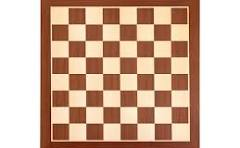

In [3]:
from google.colab import files
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

# Upload the image
uploaded = files.upload()

#  Get the uploaded filename
for file_name in uploaded.keys():
    print(f"Uploaded file: {file_name}")
    image = cv2.imread(file_name)

    #  Check if the image loaded properly
    if image is None:
        print(f"Error: Failed to load image {file_name}.")
    else:
        print(f"Image {file_name} loaded successfully!")
        original = image.copy()
        cv2_imshow(original)


# **Preprocessing the Image**

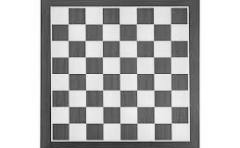

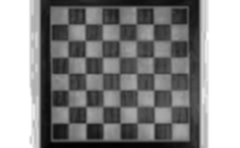

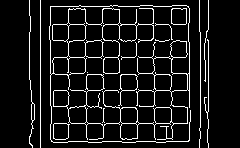

In [4]:
# Convert image to grayscale
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

# Histogram Equalization to normalize lighting
gray_eq = cv2.equalizeHist(gray)

# Reduce noise using Gaussian Blur
blurred = cv2.GaussianBlur(gray_eq, (5, 5), 0)

# Edge Detection using Canny
edges = cv2.Canny(blurred, 50, 150)

# Show intermediate results
cv2_imshow(gray)
cv2_imshow(blurred)
cv2_imshow(edges)


# **Detect Contours (to find squares)**

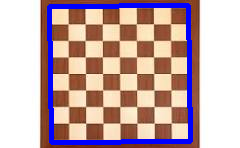

In [8]:
# Assume we already have contours list from adaptive threshold
max_area = 0
board_contour = None

for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
    area = cv2.contourArea(cnt)
    if len(approx) == 4 and area > max_area:
        max_area = area
        board_contour = approx

# Draw only the board contour
board_img = original.copy()
if board_contour is not None:
    cv2.drawContours(board_img, [board_contour], -1, (255, 0, 0), 3)
    cv2_imshow(board_img)
else:
    print("No chessboard contour detected.")


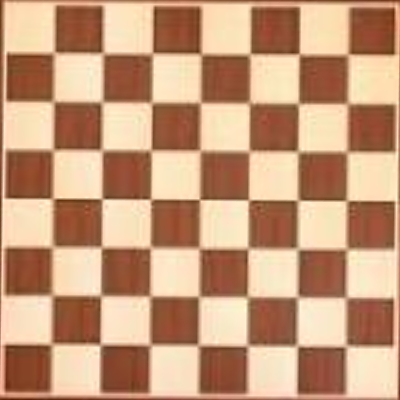

In [9]:
def order_points(pts):
    # Reorder the 4 points: [top-left, top-right, bottom-right, bottom-left]
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

if board_contour is not None:
    pts = board_contour.reshape(4, 2)
    rect = order_points(pts)

    # Resize to standard square output
    dst_size = 400
    dst_pts = np.array([[0, 0], [dst_size - 1, 0],
                        [dst_size - 1, dst_size - 1], [0, dst_size - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst_pts)
    warped = cv2.warpPerspective(original, M, (dst_size, dst_size))

    cv2_imshow(warped)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Classify Each Square as Black or White**

In [10]:
# Convert warped image to grayscale for brightness comparison
warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)

black_count = 0
white_count = 0
cell_size = dst_size // 8

for row in range(8):
    for col in range(8):
        x = col * cell_size
        y = row * cell_size
        cell = warped_gray[y:y+cell_size, x:x+cell_size]
        mean_val = np.mean(cell)

        # Simple threshold
        if mean_val < 128:
            black_count += 1
        else:
            white_count += 1

print("Black squares:", black_count)
print("White squares:", white_count)


Black squares: 32
White squares: 32
